In [1]:
import numpy as np
import sys
from sklearn.ensemble import GradientBoostingClassifier
import pandas as pd
import os
from tqdm import tqdm
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from dacs_core.vanillaBH import bh
from dacs_core.diverseSelect import cluster_exact_diverseSelect
import time

In [2]:
def one_hot_encode_column(df, column_name):
    """
    Replaces a column in a DataFrame with its one-hot encoded columns.

    Parameters:
    - df: pd.DataFrame, the input DataFrame.
    - column_name: str, the column to one-hot encode.

    Returns:
    - pd.DataFrame, the DataFrame with the specified column replaced by one-hot encoded columns.
    """
    # Ensure the column exists
    if column_name not in df.columns:
        raise ValueError(f"Column '{column_name}' not found in DataFrame.")
    
    # One-hot encode the specified column
    one_hot_encoded = pd.get_dummies(df[column_name], prefix=column_name).astype(int)
    
    # Drop the original column and concatenate the one-hot encoded columns
    df = df.drop(columns=[column_name])
    df = pd.concat([df, one_hot_encoded], axis=1)
    
    return df


In [3]:
df = pd.read_csv('Placement_Data_Full_Class.csv')
df = df[['gender', 'ssc_p', 'ssc_b', 'hsc_p', 'hsc_b', \
    'hsc_s', 'degree_p', 'degree_t', 'workex', 'etest_p',\
    'specialisation', 'mba_p', 'status']]

df = df.dropna(axis=0)

In [4]:
gender_map = {'M': 0, 'F': 1}
ssc_b_map = {'Others': 0, 'Central': 1}
hsc_b_map = {'Others': 0, 'Central': 1}
hsc_s_map = {'Commerce': 0, 'Science': 1, 'Arts': 2}
degree_t_map = {'Sci&Tech': 0, 'Comm&Mgmt': 1, 'Others': 2}
workex_map = {'No': 0, 'Yes': 1}
specialisation_map = {'Mkt&HR': 0, 'Mkt&Fin': 1}
status_map = {'Placed': 1, 'Not Placed': 0}

# cluster at the factor level

df['gender'] = df['gender'].map(gender_map)
df['ssc_b'] = df['ssc_b'].map(ssc_b_map)
df['hsc_b'] = df['hsc_b'].map(hsc_b_map)
df['hsc_s'] = df['hsc_s'].map(hsc_s_map)
df['degree_t'] = df['degree_t'].map(degree_t_map)
df['workex'] = df['workex'].map(workex_map)
df['specialisation'] = df['specialisation'].map(specialisation_map)
df['status'] = df['status'].map(status_map)

In [5]:
diversification_variable = 'gender'

X = df.drop(['status', 'gender'], axis=1).to_numpy()
Z = df[diversification_variable].to_numpy()
y = df['status'].to_numpy()

# cutoff = np.quantile(y, 0.5)
# y -= cutoff

# SETTING 1: More calib than test
dataset_length = len(y)
print(dataset_length)
ntrain = 45
n = 125
m = 45

print(len(X), len(y))

ncomponents = df[diversification_variable].nunique()

nsims = 1000
skip=1
np.random.seed(42)
def get_scores(X, Y, mu_hat):
    return np.where(Y > 0, np.inf, -mu_hat.predict_proba(X)[:,1]+0.00000001*np.random.normal(size=X.shape[0]))


setting1_freqs = []
setting1_vanilla_freqs = []
setting1_diversities = []
setting1_vanilla_diversities = []
setting1_fdrs = []
setting1_vanilla_fdrs = []
setting1_powers = []
setting1_vanilla_powers = []
setting1_overall_num_rejections = []
setting1_vanilla_overall_num_rejections = []
setting1_p0s = []
setting1_vanilla_p0s = []
setting1_times = []

setting1_serr_freqs = []
setting1_serr_vanilla_freqs = []
setting1_serr_diversities = []
setting1_serr_vanilla_diversities = []
setting1_serr_fdrs = []
setting1_serr_vanilla_fdrs = []
setting1_serr_powers = []
setting1_serr_vanilla_powers = []
setting1_serr_overall_num_rejections = []
setting1_serr_vanilla_overall_num_rejections = []
setting1_serr_times = []

alpha_list = [0.05, 0.2, 0.35]
for alpha in alpha_list:

    fdps = []
    vanilla_fdps = []

    tdps = []
    vanilla_tdps = []

    total_num_rejections = []
    vanilla_total_num_rejections = []

    total_counts = np.zeros((nsims,ncomponents))
    vanilla_total_counts = np.zeros((nsims,ncomponents))

    total_times = []
    for trial_iterator in tqdm(range(nsims)):
        perm = np.random.permutation(dataset_length)

        trainX = X[perm][:ntrain,:]
        calibX = X[perm][ntrain:ntrain+n,:]
        testX = X[perm][ntrain+n:,:]

        calibZ = Z[perm][ntrain:ntrain+n]
        testZ = Z[perm][ntrain+n:]
        
        trainY = y[perm][:ntrain]
        calibY = y[perm][ntrain:ntrain+n]
        testY = y[perm][ntrain+n:]

        muHat = GradientBoostingClassifier(learning_rate=0.1, max_depth=3, \
                                           n_estimators=50, subsample=0.7, random_state = 0)
        muHat.fit(np.array(trainX), np.array(trainY))
        
        # add noise because using gradient boosting on trees
        calibS = get_scores(calibX, calibY, muHat)
        testS = get_scores(testX, np.zeros(m), muHat)

        with open(os.devnull, 'w') as devnull:
            original_stdout = sys.stdout
            original_stderr = sys.stderr
            sys.stdout = devnull
            sys.stderr = devnull
            try:
                start = time.time()
                rejections = cluster_exact_diverseSelect(calibS, testS, n, m, alpha, np.concatenate((calibZ,testZ)), \
                                            ncomponents, skip)
                end = time.time()

                vanilla_rejections, _, __ = bh(calibS, testS, n, m, alpha)
            finally:
                sys.stdout = original_stdout
                sys.stderr = original_stderr
        

        counts = np.bincount(testZ[rejections.astype(bool)], \
                            minlength=ncomponents)
        vanilla_counts = np.bincount(testZ[vanilla_rejections.astype(bool)],\
                                minlength=ncomponents)
        
        fdp = np.sum([int(testY[i] <= 0)*int(rejections[i] == 1.) \
                                for i in range(m)])/max(1., np.sum(rejections))
        tdp = np.sum([int(testY[i] > 0)*int(rejections[i] == 1.) \
                        for i in range(m)])/max(1., np.sum([int(testY[i] > 0) \
                                                        for i in range(m)]))
        num_rejections = np.sum(rejections)

        metrics = [fdp, tdp, num_rejections]


        vanilla_fdp = np.sum([int(testY[i] <= 0)*int(vanilla_rejections[i] == 1.) \
                                for i in range(m)])/max(1., np.sum(vanilla_rejections))
        vanilla_tdp = np.sum([int(testY[i] > 0)*int(vanilla_rejections[i] == 1.) \
                        for i in range(m)])/max(1., np.sum([int(testY[i] > 0) \
                                                        for i in range(m)]))
        vanilla_num_rejections = np.sum(vanilla_rejections)

        vanilla_metrics = [vanilla_fdp, vanilla_tdp, vanilla_num_rejections]

        total_counts[trial_iterator] = np.copy(counts)
        vanilla_total_counts[trial_iterator] = np.copy(vanilla_counts)

        fdps.append(fdp)
        vanilla_fdps.append(vanilla_fdp)
        tdps.append(tdp)
        vanilla_tdps.append(vanilla_tdp)
        total_num_rejections.append(num_rejections)
        vanilla_total_num_rejections.append(vanilla_num_rejections)
        total_times.append(end-start)


    freq_arr = []
    vanilla_freq_arr = []

    p0 = 0.
    vanilla_p0 = 0.

    diversity_arr = []
    vanilla_diversity_arr = []


    for trial_iterator in range(nsims):
        if total_num_rejections[trial_iterator] > 0:
            freq_arr.append(total_counts[trial_iterator]/total_counts[trial_iterator].sum())
            diversity_arr.append(np.min(total_counts[trial_iterator])/np.sum(total_counts[trial_iterator]))
        else:
            p0 += 1.
            diversity_arr.append(-0.5)
        if vanilla_total_num_rejections[trial_iterator] > 0:
            vanilla_freq_arr.append(vanilla_total_counts[trial_iterator]/vanilla_total_counts[trial_iterator].sum())
            vanilla_diversity_arr.append(np.min(vanilla_total_counts[trial_iterator])/np.sum(vanilla_total_counts[trial_iterator]))
        else:
            vanilla_p0 += 1.
            vanilla_diversity_arr.append(-0.5)

    diversity_arr = np.array(diversity_arr)
    vanilla_diversity_arr = np.array(vanilla_diversity_arr)
    freq_arr = np.array(freq_arr)
    vanilla_freq_arr = np.array(vanilla_freq_arr)

    print(f"Results for alpha = {alpha}")
    print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
    print(f'Proportions: {np.mean(freq_arr, axis=0)}')
    print(f'Vanilla proportions: {np.mean(vanilla_freq_arr, axis=0)}')
    print(f'Diversity metric: {np.mean(diversity_arr)}')
    print(f'Vanilla diversity metric: {np.mean(vanilla_diversity_arr)}')
    print(f'Proportion of zero rejections: {p0/nsims}')
    print(f'Vanilla roportion of zero rejections: {vanilla_p0/nsims}')
    print(f'FDR: {np.mean(fdps)}')
    print(f'Vanilla FDR: {np.mean(vanilla_fdps)}')
    print(f'Power: {np.mean(tdps)}')
    print(f'Vanilla power: {np.mean(vanilla_tdps)}')
    print(f'Avg num rejections: {np.mean(total_num_rejections)}')
    print(f'Vanilla avg num rejections: {np.mean(vanilla_total_num_rejections)}')
    print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
    print()
    print()

    setting1_freqs.append(np.mean(freq_arr, axis=0))
    setting1_serr_freqs.append(np.std(freq_arr, axis=0)/np.sqrt(len(freq_arr)))
    setting1_vanilla_freqs.append(np.mean(vanilla_freq_arr, axis=0))
    setting1_serr_vanilla_freqs.append(np.std(vanilla_freq_arr, axis=0)/np.sqrt(len(vanilla_freq_arr)))
    setting1_diversities.append(np.mean(diversity_arr))
    setting1_serr_diversities.append(np.std(diversity_arr)/np.sqrt(len(diversity_arr)))
    setting1_vanilla_diversities.append(np.mean(vanilla_diversity_arr))
    setting1_serr_vanilla_diversities.append(np.std(vanilla_diversity_arr)/np.sqrt(len(vanilla_diversity_arr)))
    setting1_p0s.append(p0/nsims)
    setting1_vanilla_p0s.append(vanilla_p0/nsims)
    setting1_fdrs.append(np.mean(fdps))
    setting1_serr_fdrs.append(np.std(fdps)/np.sqrt(len(fdps)))
    setting1_vanilla_fdrs.append(np.mean(vanilla_fdps))
    setting1_serr_vanilla_fdrs.append(np.std(vanilla_fdps)/np.sqrt(len(vanilla_fdps)))
    setting1_powers.append(np.mean(tdps))
    setting1_serr_powers.append(np.std(tdps)/np.sqrt(len(tdps)))
    setting1_vanilla_powers.append(np.mean(vanilla_tdps))
    setting1_serr_vanilla_powers.append(np.std(vanilla_tdps)/np.sqrt(len(vanilla_tdps)))
    setting1_overall_num_rejections.append(np.mean(total_num_rejections))
    setting1_serr_overall_num_rejections.append(np.std(total_num_rejections)/np.sqrt(len(total_num_rejections)))
    setting1_vanilla_overall_num_rejections.append(np.mean(vanilla_total_num_rejections))
    setting1_serr_vanilla_overall_num_rejections.append(np.std(vanilla_total_num_rejections)/np.sqrt(len(vanilla_total_num_rejections)))
    setting1_times.append(np.mean(total_times))
    setting1_serr_times.append(np.std(total_times)/np.sqrt(len(total_times)))



215
215 215


  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:18<00:00, 52.66it/s]


Results for alpha = 0.05
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Proportions: [0.60125356 0.39874644]
Vanilla proportions: [0.63659522 0.36340478]
Diversity metric: 0.09275687042842216
Vanilla diversity metric: 0.06234877158228598
Proportion of zero rejections: 0.335
Vanilla roportion of zero rejections: 0.335
FDR: 0.03895734576725955
Vanilla FDR: 0.038875417908674534
Power: 0.30073270853626555
Vanilla power: 0.3425858770047801
Avg num rejections: 10.024
Vanilla avg num rejections: 11.427
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~




100%|██████████| 1000/1000 [00:41<00:00, 23.91it/s]


Results for alpha = 0.2
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Proportions: [0.56657112 0.43342888]
Vanilla proportions: [0.636978 0.363022]
Diversity metric: 0.43165044303988703
Vanilla diversity metric: 0.3608772123014656
Proportion of zero rejections: 0.0
Vanilla roportion of zero rejections: 0.0
FDR: 0.17156156068148887
Vanilla FDR: 0.19512661206949297
Power: 0.773388562751014
Vanilla power: 0.9439431280779924
Avg num rejections: 29.348
Vanilla avg num rejections: 36.803
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~




100%|██████████| 1000/1000 [01:17<00:00, 12.96it/s]

Results for alpha = 0.35
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Proportions: [0.55494482 0.44505518]
Vanilla proportions: [0.64774675 0.35225325]
Diversity metric: 0.4447781285550103
Vanilla diversity metric: 0.35160880936588873
Proportion of zero rejections: 0.0
Vanilla roportion of zero rejections: 0.0
FDR: 0.2665205757040707
Vanilla FDR: 0.3122827764650609
Power: 0.8079293862558854
Vanilla power: 0.9999051808406648
Avg num rejections: 34.378
Vanilla avg num rejections: 44.957
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~




In [6]:
diversification_variable = 'gender'

X = df.drop(['status', 'gender'], axis=1).to_numpy()
Z = df[diversification_variable].to_numpy()
y = df['status'].to_numpy()

# cutoff = np.quantile(y, 0.5)
# y -= cutoff

# SETTING 2: More test than calib
dataset_length = len(y)
print(dataset_length)
ntrain = 45
n = 45
m = 125

print(len(X), len(y))

ncomponents = df[diversification_variable].nunique()

nsims = 1000
skip=1
np.random.seed(42)
def get_scores(X, Y, mu_hat):
    return np.where(Y > 0, np.inf, -mu_hat.predict_proba(X)[:,1]+0.00000001*np.random.normal(size=X.shape[0]))


setting2_freqs = []
setting2_vanilla_freqs = []
setting2_diversities = []
setting2_vanilla_diversities = []
setting2_fdrs = []
setting2_vanilla_fdrs = []
setting2_powers = []
setting2_vanilla_powers = []
setting2_overall_num_rejections = []
setting2_vanilla_overall_num_rejections = []
setting2_p0s = []
setting2_vanilla_p0s = []
setting2_times = []

setting2_serr_freqs = []
setting2_serr_vanilla_freqs = []
setting2_serr_diversities = []
setting2_serr_vanilla_diversities = []
setting2_serr_fdrs = []
setting2_serr_vanilla_fdrs = []
setting2_serr_powers = []
setting2_serr_vanilla_powers = []
setting2_serr_overall_num_rejections = []
setting2_serr_vanilla_overall_num_rejections = []
setting2_times = []
setting2_serr_times = []

alpha_list = [0.05, 0.2, 0.35]
for alpha in alpha_list:

    fdps = []
    vanilla_fdps = []

    tdps = []
    vanilla_tdps = []

    total_num_rejections = []
    vanilla_total_num_rejections = []

    total_counts = np.zeros((nsims,ncomponents))
    vanilla_total_counts = np.zeros((nsims,ncomponents))

    total_times = []
    for trial_iterator in tqdm(range(nsims)):
        perm = np.random.permutation(dataset_length)

        trainX = X[perm][:ntrain,:]
        calibX = X[perm][ntrain:ntrain+n,:]
        testX = X[perm][ntrain+n:,:]

        calibZ = Z[perm][ntrain:ntrain+n]
        testZ = Z[perm][ntrain+n:]
        
        trainY = y[perm][:ntrain]
        calibY = y[perm][ntrain:ntrain+n]
        testY = y[perm][ntrain+n:]

        muHat = GradientBoostingClassifier(learning_rate=0.1, max_depth=3, \
                                           n_estimators=50, subsample=0.7, random_state = 0)
        muHat.fit(np.array(trainX), np.array(trainY))
        
        # add noise because using gradient boosting on trees
        calibS = get_scores(calibX, calibY, muHat)
        testS = get_scores(testX, np.zeros(m), muHat)

        with open(os.devnull, 'w') as devnull:
            original_stdout = sys.stdout
            original_stderr = sys.stderr
            sys.stdout = devnull
            sys.stderr = devnull
            try:
                start = time.time()
                rejections = cluster_exact_diverseSelect(calibS, testS, n, m, alpha, np.concatenate((calibZ,testZ)), \
                                            ncomponents, skip)
                end = time.time()

                vanilla_rejections, _, __ = bh(calibS, testS, n, m, alpha)
            finally:
                sys.stdout = original_stdout
                sys.stderr = original_stderr
        

        counts = np.bincount(testZ[rejections.astype(bool)], \
                            minlength=ncomponents)
        vanilla_counts = np.bincount(testZ[vanilla_rejections.astype(bool)],\
                                minlength=ncomponents)
        
        fdp = np.sum([int(testY[i] <= 0)*int(rejections[i] == 1.) \
                                for i in range(m)])/max(1., np.sum(rejections))
        tdp = np.sum([int(testY[i] > 0)*int(rejections[i] == 1.) \
                        for i in range(m)])/max(1., np.sum([int(testY[i] > 0) \
                                                        for i in range(m)]))
        num_rejections = np.sum(rejections)

        metrics = [fdp, tdp, num_rejections]


        vanilla_fdp = np.sum([int(testY[i] <= 0)*int(vanilla_rejections[i] == 1.) \
                                for i in range(m)])/max(1., np.sum(vanilla_rejections))
        vanilla_tdp = np.sum([int(testY[i] > 0)*int(vanilla_rejections[i] == 1.) \
                        for i in range(m)])/max(1., np.sum([int(testY[i] > 0) \
                                                        for i in range(m)]))
        vanilla_num_rejections = np.sum(vanilla_rejections)

        vanilla_metrics = [vanilla_fdp, vanilla_tdp, vanilla_num_rejections]

        total_counts[trial_iterator] = np.copy(counts)
        vanilla_total_counts[trial_iterator] = np.copy(vanilla_counts)

        fdps.append(fdp)
        vanilla_fdps.append(vanilla_fdp)
        tdps.append(tdp)
        vanilla_tdps.append(vanilla_tdp)
        total_num_rejections.append(num_rejections)
        vanilla_total_num_rejections.append(vanilla_num_rejections)
        total_times.append(end-start)


    freq_arr = []
    vanilla_freq_arr = []

    p0 = 0.
    vanilla_p0 = 0.

    diversity_arr = []
    vanilla_diversity_arr = []


    for trial_iterator in range(nsims):
        if total_num_rejections[trial_iterator] > 0:
            freq_arr.append(total_counts[trial_iterator]/total_counts[trial_iterator].sum())
            diversity_arr.append(np.min(total_counts[trial_iterator])/np.sum(total_counts[trial_iterator]))
        else:
            p0 += 1.
            diversity_arr.append(-0.5)
        if vanilla_total_num_rejections[trial_iterator] > 0:
            vanilla_freq_arr.append(vanilla_total_counts[trial_iterator]/vanilla_total_counts[trial_iterator].sum())
            vanilla_diversity_arr.append(np.min(vanilla_total_counts[trial_iterator])/np.sum(vanilla_total_counts[trial_iterator]))
        else:
            vanilla_p0 += 1.
            vanilla_diversity_arr.append(-0.5)

    diversity_arr = np.array(diversity_arr)
    vanilla_diversity_arr = np.array(vanilla_diversity_arr)
    freq_arr = np.array(freq_arr)
    vanilla_freq_arr = np.array(vanilla_freq_arr)

    print(f"Results for alpha = {alpha}")
    print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
    print(f'Proportions: {np.mean(freq_arr, axis=0)}')
    print(f'Vanilla proportions: {np.mean(vanilla_freq_arr, axis=0)}')
    print(f'Diversity metric: {np.mean(diversity_arr)}')
    print(f'Vanilla diversity metric: {np.mean(vanilla_diversity_arr)}')
    print(f'Proportion of zero rejections: {p0/nsims}')
    print(f'Vanilla roportion of zero rejections: {vanilla_p0/nsims}')
    print(f'FDR: {np.mean(fdps)}')
    print(f'Vanilla FDR: {np.mean(vanilla_fdps)}')
    print(f'Power: {np.mean(tdps)}')
    print(f'Vanilla power: {np.mean(vanilla_tdps)}')
    print(f'Avg num rejections: {np.mean(total_num_rejections)}')
    print(f'Vanilla avg num rejections: {np.mean(vanilla_total_num_rejections)}')
    print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
    print()
    print()

    setting2_freqs.append(np.mean(freq_arr, axis=0))
    setting2_serr_freqs.append(np.std(freq_arr, axis=0)/np.sqrt(len(freq_arr)))
    setting2_vanilla_freqs.append(np.mean(vanilla_freq_arr, axis=0))
    setting2_serr_vanilla_freqs.append(np.std(vanilla_freq_arr, axis=0)/np.sqrt(len(vanilla_freq_arr)))
    setting2_diversities.append(np.mean(diversity_arr))
    setting2_serr_diversities.append(np.std(diversity_arr)/np.sqrt(len(diversity_arr)))
    setting2_vanilla_diversities.append(np.mean(vanilla_diversity_arr))
    setting2_serr_vanilla_diversities.append(np.std(vanilla_diversity_arr)/np.sqrt(len(vanilla_diversity_arr)))
    setting2_p0s.append(p0/nsims)
    setting2_vanilla_p0s.append(vanilla_p0/nsims)
    setting2_fdrs.append(np.mean(fdps))
    setting2_serr_fdrs.append(np.std(fdps)/np.sqrt(len(fdps)))
    setting2_vanilla_fdrs.append(np.mean(vanilla_fdps))
    setting2_serr_vanilla_fdrs.append(np.std(vanilla_fdps)/np.sqrt(len(vanilla_fdps)))
    setting2_powers.append(np.mean(tdps))
    setting2_serr_powers.append(np.std(tdps)/np.sqrt(len(tdps)))
    setting2_vanilla_powers.append(np.mean(vanilla_tdps))
    setting2_serr_vanilla_powers.append(np.std(vanilla_tdps)/np.sqrt(len(vanilla_tdps)))
    setting2_overall_num_rejections.append(np.mean(total_num_rejections))
    setting2_serr_overall_num_rejections.append(np.std(total_num_rejections)/np.sqrt(len(total_num_rejections)))
    setting2_vanilla_overall_num_rejections.append(np.mean(vanilla_total_num_rejections))
    setting2_serr_vanilla_overall_num_rejections.append(np.std(vanilla_total_num_rejections)/np.sqrt(len(vanilla_total_num_rejections)))
    setting2_times.append(np.mean(total_times))
    setting2_serr_times.append(np.std(total_times)/np.sqrt(len(total_times)))



215
215 215


100%|██████████| 1000/1000 [00:20<00:00, 49.79it/s]


Results for alpha = 0.05
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Proportions: [0.56800144 0.43199856]
Vanilla proportions: [0.62440589 0.37559411]
Diversity metric: -0.2651909090909091
Vanilla diversity metric: -0.27863816733217345
Proportion of zero rejections: 0.748
Vanilla roportion of zero rejections: 0.747
FDR: 0.02522496222720512
Vanilla FDR: 0.024144731192816862
Power: 0.15031894759544892
Vanilla power: 0.17647572254975238
Avg num rejections: 14.411
Vanilla avg num rejections: 16.866
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~




100%|██████████| 1000/1000 [00:55<00:00, 17.97it/s]


Results for alpha = 0.2
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Proportions: [0.52545862 0.47454138]
Vanilla proportions: [0.63766364 0.36233636]
Diversity metric: 0.460897799474557
Vanilla diversity metric: 0.3563000087284127
Proportion of zero rejections: 0.014
Vanilla roportion of zero rejections: 0.007
FDR: 0.10701848327279653
Vanilla FDR: 0.18891046113743537
Power: 0.548723688786293
Vanilla power: 0.9039003797797166
Avg num rejections: 53.193
Vanilla avg num rejections: 97.404
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~




100%|██████████| 1000/1000 [01:35<00:00, 10.50it/s]

Results for alpha = 0.35
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Proportions: [0.50176539 0.49823461]
Vanilla proportions: [0.64756948 0.35243052]
Diversity metric: 0.49823460615131204
Vanilla diversity metric: 0.35243051847527024
Proportion of zero rejections: 0.0
Vanilla roportion of zero rejections: 0.0
FDR: 0.1346941959121429
Vanilla FDR: 0.2992553869152257
Power: 0.5768919656894489
Vanilla power: 0.9971883055766464
Avg num rejections: 57.705
Vanilla avg num rejections: 122.591
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~




In [7]:
freqs_for_df = []
sim_setting_for_df = []
alphas_for_df = []
cluster_for_df = []
method_for_df = []
settings_for_df = []
serrR = []

alphas = ['alpha = 0.05', 'alpha = 0.2', 'alpha = 0.35']

freqs = [setting1_freqs, setting2_freqs]
serr_freqs = [setting1_serr_freqs, setting2_serr_freqs]
vanilla_freqs = [setting1_vanilla_freqs, setting2_vanilla_freqs]
serr_vanilla_freqs = [setting1_serr_vanilla_freqs, setting2_serr_vanilla_freqs]
for alpha_ind in range(3):
    for setting_ind in range(2):
        freq = freqs[setting_ind][alpha_ind]
        serr_freq = serr_freqs[setting_ind][alpha_ind]
        for c in range(len(freq)):
            freqs_for_df.append(freq[c])
            alphas_for_df.append(alphas[alpha_ind])
            cluster_for_df.append(c)
            method_for_df.append("DACS")
            serrR.append(serr_freq[c])
            settings_for_df.append(['Setting 1', 'Setting 2'][setting_ind])
    
    for setting_ind in range(2):
        vanilla_freq = vanilla_freqs[setting_ind][alpha_ind]
        vanilla_serr_freq = serr_vanilla_freqs[setting_ind][alpha_ind]
        for c in range(len(freq)):
            freqs_for_df.append(vanilla_freq[c])
            alphas_for_df.append(alphas[alpha_ind])
            cluster_for_df.append(c)
            method_for_df.append("CS")
            serrR.append(vanilla_serr_freq[c])
            settings_for_df.append(['Setting 1', 'Setting 2'][setting_ind])

lines_prop0s = []
lines_alphas = []
lines_method = []
lines_setting = []

p0s = [setting1_p0s, setting2_p0s]
vanilla_p0s = [setting1_vanilla_p0s, setting2_vanilla_p0s]
for alpha_ind in range(3):
    for setting_ind in range(2):
        prop0 = p0s[setting_ind][alpha_ind]
        lines_prop0s.append(prop0)
        lines_alphas.append(alphas[alpha_ind])
        lines_method.append('DACS')
        lines_setting.append(['Setting 1', 'Setting 2'][setting_ind])

        vanilla_prop0 = vanilla_p0s[setting_ind][alpha_ind]
        lines_prop0s.append(vanilla_prop0)
        lines_alphas.append(alphas[alpha_ind])
        lines_method.append('CS')
        lines_setting.append(['Setting 1', 'Setting 2'][setting_ind])

df_exper_prop = pd.DataFrame({
    'proportions': freqs_for_df,
    'alpha': alphas_for_df,
    'cluster': cluster_for_df,
    'method': method_for_df,
    'serr': serrR,
    'setting': settings_for_df
})

df_exper_lines = pd.DataFrame({
    'p0': lines_prop0s,
    'alpha': lines_alphas,
    'method': lines_method,
    'setting': lines_setting
})

df_exper_prop.to_csv('./csvs_to_plot/exper_results_for_R.csv')
df_exper_lines.to_csv('./csvs_to_plot/line_exper_results_for_R.csv')

In [8]:
mt_metrics_for_df= []
cluster_fdp_tdp_numr_for_df = []
method_for_df = []
alphas_for_df = []
method_for_df = []
serrR = []
settingsR = []

fdrs = [setting1_fdrs, setting2_fdrs]
powers = [setting1_powers, setting2_powers]
serr_fdrs = [setting1_serr_fdrs, setting2_serr_fdrs]
serr_powers = [setting1_serr_powers, setting2_serr_powers]

vanilla_fdrs = [setting1_vanilla_fdrs, setting2_vanilla_fdrs]
vanilla_powers = [setting1_vanilla_powers, setting2_vanilla_powers]
serr_vanilla_fdrs = [setting1_serr_vanilla_fdrs, setting2_serr_vanilla_fdrs]
serr_vanilla_powers = [setting1_serr_vanilla_powers, setting2_serr_vanilla_powers]
for alpha_ind in range(3):
    for c in range(2):
        for setting_ind in range(2):
            mt_metrics_for_df.append(fdrs[setting_ind][alpha_ind] if c == 0 else powers[setting_ind][alpha_ind])
            alphas_for_df.append(alphas[alpha_ind])
            cluster_fdp_tdp_numr_for_df.append(['FDP', 'Power', '#R'][c])
            method_for_df.append("DACS")
            serrR.append(serr_fdrs[setting_ind][alpha_ind] if c == 0 else serr_powers[setting_ind][alpha_ind])
            settingsR.append(['Setting 1', 'Setting 2'][setting_ind])


            mt_metrics_for_df.append(vanilla_fdrs[setting_ind][alpha_ind] if c == 0 else vanilla_powers[setting_ind][alpha_ind])
            alphas_for_df.append(alphas[alpha_ind])
            cluster_fdp_tdp_numr_for_df.append(['FDP', 'Power', '#R'][c])
            method_for_df.append("CS")
            serrR.append(serr_vanilla_fdrs[setting_ind][alpha_ind] if c == 0 else serr_vanilla_powers[setting_ind][alpha_ind])
            settingsR.append(['Setting 1', 'Setting 2'][setting_ind])

exper_mt_metric_df = pd.DataFrame({
    'rate': mt_metrics_for_df,
    'alpha': alphas_for_df,
    'error_metric': cluster_fdp_tdp_numr_for_df,
    'method': method_for_df,
    'serr': serrR,
    'setting': settingsR
})

exper_mt_metric_df.to_csv('./csvs_to_plot/exper_mt_metric_results_for_R.csv')

In [9]:
mt_metrics_for_df= []
cluster_fdp_tdp_numr_for_df = []
method_for_df = []
alphas_for_df = []
method_for_df = []
serrR = []
settingsR = []


overall_num_rejections = [setting1_overall_num_rejections, setting2_overall_num_rejections]
serr_overall_num_rejections = [setting1_serr_overall_num_rejections, setting2_serr_overall_num_rejections]
vanilla_overall_num_rejections = [setting1_vanilla_overall_num_rejections, setting2_vanilla_overall_num_rejections]
serr_vanilla_overall_num_rejections = [setting1_serr_vanilla_overall_num_rejections, setting2_serr_vanilla_overall_num_rejections]

for alpha_ind in range(3):
    for c in [2]:
        for setting_indexer in range(2):
            mt_metrics_for_df.append(overall_num_rejections[setting_indexer][alpha_ind])
            alphas_for_df.append(alphas[alpha_ind])
            cluster_fdp_tdp_numr_for_df.append(['FDP', 'TDP', '#R'][c])
            method_for_df.append("DACS")
            serrR.append(serr_overall_num_rejections[setting_indexer][alpha_ind])
            settingsR.append(['Setting 1', 'Setting 2'][setting_indexer])


            mt_metrics_for_df.append(vanilla_overall_num_rejections[setting_indexer][alpha_ind])
            alphas_for_df.append(alphas[alpha_ind])
            cluster_fdp_tdp_numr_for_df.append(['FDP', 'TDP', '#R'][c])
            method_for_df.append("CS")
            serrR.append(serr_vanilla_overall_num_rejections[setting_indexer][alpha_ind])
            settingsR.append(['Setting 1', 'Setting 2'][setting_indexer])

exper_mt_metric_numr_df = pd.DataFrame({
    '#R': mt_metrics_for_df,
    'alpha': alphas_for_df,
    'num_rejections': cluster_fdp_tdp_numr_for_df,
    'method': method_for_df,
    'serr': serrR,
    'setting': settingsR
})

exper_mt_metric_numr_df.to_csv('./csvs_to_plot/exper_mt_metric_numr_results_for_R.csv')

In [10]:
diversity_for_df= []
alphas_for_df = []
method_for_df = []
serrR = []
settingsR = []

diversities = [setting1_diversities, setting2_diversities]
serr_diversities = [setting1_serr_diversities, setting2_serr_diversities]

vanilla_diversities = [setting1_vanilla_diversities, setting2_vanilla_diversities]
serr_vanilla_diversities = [setting1_serr_vanilla_diversities, setting2_serr_vanilla_diversities]


for alpha_ind in range(3):
    for setting_ind in range(2):
        diversity_for_df.append(diversities[setting_ind][alpha_ind])
        alphas_for_df.append(alphas[alpha_ind])
        method_for_df.append("DACS")
        serrR.append(serr_diversities[setting_ind][alpha_ind])
        settingsR.append(['Setting 1', 'Setting 2'][setting_ind])

        diversity_for_df.append(vanilla_diversities[setting_ind][alpha_ind])
        alphas_for_df.append(alphas[alpha_ind])
        method_for_df.append("CS")
        serrR.append(serr_vanilla_diversities[setting_ind][alpha_ind])
        settingsR.append(['Setting 1', 'Setting 2'][setting_ind])

diversity_df_exper = pd.DataFrame({
    'underrep_ind': diversity_for_df,
    'alpha': alphas_for_df,
    'method': method_for_df,
    'diversity': ['diversity']*len(method_for_df),
    'serr': serrR,
    'setting': settingsR
})

diversity_df_exper.to_csv('./csvs_to_plot/exper_diversity_results_for_R.csv')

In [11]:
time_for_df= []
alphas_for_df = []
serrR = []
settingsR = []

times = [setting1_times, setting2_times]
serr_times = [setting1_serr_times, setting2_serr_times]



for alpha_ind in range(3):
    for setting_ind in range(2):
        time_for_df.append(times[setting_ind][alpha_ind])
        alphas_for_df.append(alphas[alpha_ind])
        serrR.append(serr_times[setting_ind][alpha_ind])
        settingsR.append(['Setting 1', 'Setting 2'][setting_ind])

diversity_df_exper = pd.DataFrame({
    'Time (sec)': time_for_df,
    'alpha': alphas_for_df,
    'time': ['time']*len(settingsR),
    'serr': serrR,
    'setting': settingsR
})

diversity_df_exper.to_csv('./csvs_to_plot/exper_time_results_for_R.csv')

In [12]:
# compute pi0 and conditional pi0s
print(f'pi0: {np.mean((df["status"].to_numpy() <= 0).astype(int))}')
print(f'Men pi0: {np.mean((df[df["gender"] == 0]["status"].to_numpy() <= 0).astype(int))}')
print(f'Women pi0: {np.mean((df[df["gender"] == 1]["status"].to_numpy() <= 0).astype(int))}')



pi0: 0.3116279069767442
Men pi0: 0.2805755395683453
Women pi0: 0.3684210526315789


In [13]:
diversification_variable = 'gender'

X = df.drop(['status', 'gender'], axis=1).to_numpy()
Z = df[diversification_variable].to_numpy()
y = df['status'].to_numpy()

# cutoff = np.quantile(y, 0.5)
# y -= cutoff

# SETTING 1: More calib than test
dataset_length = len(y)
print(dataset_length)
ntrain = 45
n = 125
m = 45

print(len(X), len(y))

ncomponents = df[diversification_variable].nunique()

nsims = 1000
skip=1
np.random.seed(42)
def get_scores(X, Y, mu_hat):
    return np.where(Y > 0, np.inf, -mu_hat.predict_proba(X)[:,1]+0.00000001*np.random.normal(size=X.shape[0]))


setting1_freqs = []
setting1_vanilla_freqs = []
setting1_diversities = []
setting1_vanilla_diversities = []
setting1_fdrs = []
setting1_vanilla_fdrs = []
setting1_powers = []
setting1_vanilla_powers = []
setting1_overall_num_rejections = []
setting1_vanilla_overall_num_rejections = []
setting1_p0s = []
setting1_vanilla_p0s = []

setting1_serr_freqs = []
setting1_serr_vanilla_freqs = []
setting1_serr_diversities = []
setting1_serr_vanilla_diversities = []
setting1_serr_fdrs = []
setting1_serr_vanilla_fdrs = []
setting1_serr_powers = []
setting1_serr_vanilla_powers = []
setting1_serr_overall_num_rejections = []
setting1_serr_vanilla_overall_num_rejections = []

alpha_list = np.linspace(0.05, 0.35, 50)
for alpha in alpha_list:
    fdps = []
    vanilla_fdps = []

    tdps = []
    vanilla_tdps = []

    total_num_rejections = []
    vanilla_total_num_rejections = []

    total_counts = np.zeros((nsims,ncomponents))
    vanilla_total_counts = np.zeros((nsims,ncomponents))
    for trial_iterator in tqdm(range(nsims)):
        perm = np.random.permutation(dataset_length)

        trainX = X[perm][:ntrain,:]
        calibX = X[perm][ntrain:ntrain+n,:]
        testX = X[perm][ntrain+n:,:]

        calibZ = Z[perm][ntrain:ntrain+n]
        testZ = Z[perm][ntrain+n:]
        
        trainY = y[perm][:ntrain]
        calibY = y[perm][ntrain:ntrain+n]
        testY = y[perm][ntrain+n:]

        muHat = GradientBoostingClassifier(learning_rate=0.1, max_depth=3, \
                                           n_estimators=50, subsample=0.7, random_state = 0)
        muHat.fit(np.array(trainX), np.array(trainY))
        
        # add noise because using gradient boosting on trees
        calibS = get_scores(calibX, calibY, muHat)
        testS = get_scores(testX, np.zeros(m), muHat)

        with open(os.devnull, 'w') as devnull:
            original_stdout = sys.stdout
            original_stderr = sys.stderr
            sys.stdout = devnull
            sys.stderr = devnull
            try:
                rejections = cluster_exact_diverseSelect(calibS, testS, n, m, alpha, np.concatenate((calibZ,testZ)), \
                                            ncomponents, skip)

                vanilla_rejections, _, __ = bh(calibS, testS, n, m, alpha)
            finally:
                sys.stdout = original_stdout
                sys.stderr = original_stderr
        

        counts = np.bincount(testZ[rejections.astype(bool)], \
                            minlength=ncomponents)
        vanilla_counts = np.bincount(testZ[vanilla_rejections.astype(bool)],\
                                minlength=ncomponents)
        
        fdp = np.sum([int(testY[i] <= 0)*int(rejections[i] == 1.) \
                                for i in range(m)])/max(1., np.sum(rejections))
        tdp = np.sum([int(testY[i] > 0)*int(rejections[i] == 1.) \
                        for i in range(m)])/max(1., np.sum([int(testY[i] > 0) \
                                                        for i in range(m)]))
        num_rejections = np.sum(rejections)

        metrics = [fdp, tdp, num_rejections]


        vanilla_fdp = np.sum([int(testY[i] <= 0)*int(vanilla_rejections[i] == 1.) \
                                for i in range(m)])/max(1., np.sum(vanilla_rejections))
        vanilla_tdp = np.sum([int(testY[i] > 0)*int(vanilla_rejections[i] == 1.) \
                        for i in range(m)])/max(1., np.sum([int(testY[i] > 0) \
                                                        for i in range(m)]))
        vanilla_num_rejections = np.sum(vanilla_rejections)

        vanilla_metrics = [vanilla_fdp, vanilla_tdp, vanilla_num_rejections]

        total_counts[trial_iterator] = np.copy(counts)
        vanilla_total_counts[trial_iterator] = np.copy(vanilla_counts)

        fdps.append(fdp)
        vanilla_fdps.append(vanilla_fdp)
        tdps.append(tdp)
        vanilla_tdps.append(vanilla_tdp)
        total_num_rejections.append(num_rejections)
        vanilla_total_num_rejections.append(vanilla_num_rejections)


    freq_arr = []
    vanilla_freq_arr = []

    p0 = 0.
    vanilla_p0 = 0.

    diversity_arr = []
    vanilla_diversity_arr = []


    for trial_iterator in range(nsims):
        if total_num_rejections[trial_iterator] > 0:
            freq_arr.append(total_counts[trial_iterator]/total_counts[trial_iterator].sum())
            diversity_arr.append(np.min(total_counts[trial_iterator])/np.sum(total_counts[trial_iterator]))
        else:
            p0 += 1.
            diversity_arr.append(-0.5)
        if vanilla_total_num_rejections[trial_iterator] > 0:
            vanilla_freq_arr.append(vanilla_total_counts[trial_iterator]/vanilla_total_counts[trial_iterator].sum())
            vanilla_diversity_arr.append(np.min(vanilla_total_counts[trial_iterator])/np.sum(vanilla_total_counts[trial_iterator]))
        else:
            vanilla_p0 += 1.
            vanilla_diversity_arr.append(-0.5)

    diversity_arr = np.array(diversity_arr)
    vanilla_diversity_arr = np.array(vanilla_diversity_arr)
    freq_arr = np.array(freq_arr)
    vanilla_freq_arr = np.array(vanilla_freq_arr)

    print(f"Results for alpha = {alpha}")
    print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
    print(f'Proportions: {np.mean(freq_arr, axis=0)}')
    print(f'Vanilla proportions: {np.mean(vanilla_freq_arr, axis=0)}')
    print(f'Diversity metric: {np.mean(diversity_arr)}')
    print(f'Vanilla diversity metric: {np.mean(vanilla_diversity_arr)}')
    print(f'Proportion of zero rejections: {p0/nsims}')
    print(f'Vanilla roportion of zero rejections: {vanilla_p0/nsims}')
    print(f'FDR: {np.mean(fdps)}')
    print(f'Vanilla FDR: {np.mean(vanilla_fdps)}')
    print(f'Power: {np.mean(tdps)}')
    print(f'Vanilla power: {np.mean(vanilla_tdps)}')
    print(f'Avg num rejections: {np.mean(total_num_rejections)}')
    print(f'Vanilla avg num rejections: {np.mean(vanilla_total_num_rejections)}')
    print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
    print()
    print()

    setting1_freqs.append(np.mean(freq_arr, axis=0))
    setting1_serr_freqs.append(np.std(freq_arr, axis=0)/np.sqrt(len(freq_arr)))
    setting1_vanilla_freqs.append(np.mean(vanilla_freq_arr, axis=0))
    setting1_serr_vanilla_freqs.append(np.std(vanilla_freq_arr, axis=0)/np.sqrt(len(vanilla_freq_arr)))
    setting1_diversities.append(np.mean(diversity_arr))
    setting1_serr_diversities.append(np.std(diversity_arr)/np.sqrt(len(diversity_arr)))
    setting1_vanilla_diversities.append(np.mean(vanilla_diversity_arr))
    setting1_serr_vanilla_diversities.append(np.std(vanilla_diversity_arr)/np.sqrt(len(vanilla_diversity_arr)))
    setting1_p0s.append(p0/nsims)
    setting1_vanilla_p0s.append(vanilla_p0/nsims)
    setting1_fdrs.append(np.mean(fdps))
    setting1_serr_fdrs.append(np.std(fdps)/np.sqrt(len(fdps)))
    setting1_vanilla_fdrs.append(np.mean(vanilla_fdps))
    setting1_serr_vanilla_fdrs.append(np.std(vanilla_fdps)/np.sqrt(len(vanilla_fdps)))
    setting1_powers.append(np.mean(tdps))
    setting1_serr_powers.append(np.std(tdps)/np.sqrt(len(tdps)))
    setting1_vanilla_powers.append(np.mean(vanilla_tdps))
    setting1_serr_vanilla_powers.append(np.std(vanilla_tdps)/np.sqrt(len(vanilla_tdps)))
    setting1_overall_num_rejections.append(np.mean(total_num_rejections))
    setting1_serr_overall_num_rejections.append(np.std(total_num_rejections)/np.sqrt(len(total_num_rejections)))
    setting1_vanilla_overall_num_rejections.append(np.mean(vanilla_total_num_rejections))
    setting1_serr_vanilla_overall_num_rejections.append(np.std(vanilla_total_num_rejections)/np.sqrt(len(vanilla_total_num_rejections)))



215
215 215


100%|██████████| 1000/1000 [00:17<00:00, 56.79it/s]


Results for alpha = 0.05
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Proportions: [0.60125356 0.39874644]
Vanilla proportions: [0.63659522 0.36340478]
Diversity metric: 0.09275687042842216
Vanilla diversity metric: 0.06234877158228598
Proportion of zero rejections: 0.335
Vanilla roportion of zero rejections: 0.335
FDR: 0.03895734576725955
Vanilla FDR: 0.038875417908674534
Power: 0.30073270853626555
Vanilla power: 0.3425858770047801
Avg num rejections: 10.024
Vanilla avg num rejections: 11.427
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~




100%|██████████| 1000/1000 [00:18<00:00, 52.83it/s]


Results for alpha = 0.05612244897959184
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Proportions: [0.60055541 0.39944459]
Vanilla proportions: [0.63595729 0.36404271]
Diversity metric: 0.1782932692307692
Vanilla diversity metric: 0.14759180645191303
Proportion of zero rejections: 0.24
Vanilla roportion of zero rejections: 0.239
FDR: 0.04361153846153846
Vanilla FDR: 0.04404233581507469
Power: 0.3645408186820845
Vanilla power: 0.411362540480004
Avg num rejections: 12.238
Vanilla avg num rejections: 13.814
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~




100%|██████████| 1000/1000 [00:19<00:00, 50.94it/s]


Results for alpha = 0.06224489795918368
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Proportions: [0.59338691 0.40661309]
Vanilla proportions: [0.62851394 0.37148606]
Diversity metric: 0.2238502213179125
Vanilla diversity metric: 0.1898001208877049
Proportion of zero rejections: 0.197
Vanilla roportion of zero rejections: 0.194
FDR: 0.05354116743243429
Vanilla FDR: 0.054043345062421665
Power: 0.39783586001916826
Vanilla power: 0.45410548951899854
Avg num rejections: 13.385
Vanilla avg num rejections: 15.293
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~




100%|██████████| 1000/1000 [00:19<00:00, 50.97it/s]


Results for alpha = 0.06836734693877551
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Proportions: [0.59303785 0.40696215]
Vanilla proportions: [0.62844926 0.37155074]
Diversity metric: 0.26782645957645956
Vanilla diversity metric: 0.2339577293940464
Proportion of zero rejections: 0.146
Vanilla roportion of zero rejections: 0.144
FDR: 0.059312557250057255
Vanilla FDR: 0.060535838029919145
Power: 0.43953995781831406
Vanilla power: 0.5031729623283848
Avg num rejections: 14.762
Vanilla avg num rejections: 16.95
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~




100%|██████████| 1000/1000 [00:19<00:00, 50.33it/s]


Results for alpha = 0.07448979591836735
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Proportions: [0.59287504 0.40712496]
Vanilla proportions: [0.62841307 0.37158693]
Diversity metric: 0.2902761663286004
Vanilla diversity metric: 0.25518947353447063
Proportion of zero rejections: 0.118
Vanilla roportion of zero rejections: 0.115
FDR: 0.06308682350582706
Vanilla FDR: 0.0653014887437634
Power: 0.4687167959512192
Vanilla power: 0.5348707787521444
Avg num rejections: 15.854
Vanilla avg num rejections: 18.126
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~




100%|██████████| 1000/1000 [00:21<00:00, 46.27it/s]


Results for alpha = 0.08061224489795918
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Proportions: [0.59093345 0.40906655]
Vanilla proportions: [0.633246 0.366754]
Diversity metric: 0.32007850241545893
Vanilla diversity metric: 0.2812487039510847
Proportion of zero rejections: 0.09
Vanilla roportion of zero rejections: 0.084
FDR: 0.06966884149229098
Vanilla FDR: 0.07204101823283494
Power: 0.4923763033366499
Vanilla power: 0.5760941847254847
Avg num rejections: 16.776
Vanilla avg num rejections: 19.672
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~




100%|██████████| 1000/1000 [00:21<00:00, 46.62it/s]


Results for alpha = 0.08673469387755102
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Proportions: [0.59697618 0.40302382]
Vanilla proportions: [0.63044945 0.36955055]
Diversity metric: 0.33309741995285713
Vanilla diversity metric: 0.29959734908302027
Proportion of zero rejections: 0.07
Vanilla roportion of zero rejections: 0.068
FDR: 0.07825341358943834
Vanilla FDR: 0.08150330283104146
Power: 0.5459640067105795
Vanilla power: 0.6167665052006935
Avg num rejections: 18.708
Vanilla avg num rejections: 21.243
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~




100%|██████████| 1000/1000 [00:21<00:00, 45.88it/s]


Results for alpha = 0.09285714285714286
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Proportions: [0.59240886 0.40759114]
Vanilla proportions: [0.63609291 0.36390709]
Diversity metric: 0.3324965188336156
Vanilla diversity metric: 0.29270609489227983
Proportion of zero rejections: 0.079
Vanilla roportion of zero rejections: 0.073
FDR: 0.0770953110667532
Vanilla FDR: 0.08148681672929033
Power: 0.5248469146363095
Vanilla power: 0.61644902967613
Avg num rejections: 17.956
Vanilla avg num rejections: 21.21
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~




100%|██████████| 1000/1000 [00:23<00:00, 42.51it/s]


Results for alpha = 0.09897959183673469
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Proportions: [0.58880401 0.41119599]
Vanilla proportions: [0.62535629 0.37464371]
Diversity metric: 0.34943261946029647
Vanilla diversity metric: 0.3122123441847395
Proportion of zero rejections: 0.06
Vanilla roportion of zero rejections: 0.056
FDR: 0.08479090338468206
Vanilla FDR: 0.09088458129478375
Power: 0.5677280033762422
Vanilla power: 0.6503634405149048
Avg num rejections: 19.503
Vanilla avg num rejections: 22.543
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~




100%|██████████| 1000/1000 [00:23<00:00, 42.49it/s]


Results for alpha = 0.10510204081632653
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Proportions: [0.59226222 0.40773778]
Vanilla proportions: [0.63258116 0.36741884]
Diversity metric: 0.3637840861533686
Vanilla diversity metric: 0.321955261006075
Proportion of zero rejections: 0.046
Vanilla roportion of zero rejections: 0.044
FDR: 0.09339821488087242
Vanilla FDR: 0.0980844479908136
Power: 0.5952234908616092
Vanilla power: 0.684737869639597
Avg num rejections: 20.734
Vanilla avg num rejections: 23.989
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~




100%|██████████| 1000/1000 [00:25<00:00, 39.42it/s]


Results for alpha = 0.11122448979591837
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Proportions: [0.59112507 0.40887493]
Vanilla proportions: [0.63602001 0.36397999]
Diversity metric: 0.3845498372652619
Vanilla diversity metric: 0.33786537978609543
Proportion of zero rejections: 0.025
Vanilla roportion of zero rejections: 0.024
FDR: 0.0980840549052683
Vanilla FDR: 0.10481374533044475
Power: 0.6231181665953088
Vanilla power: 0.7209896705505663
Avg num rejections: 21.802
Vanilla avg num rejections: 25.436
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~




100%|██████████| 1000/1000 [00:25<00:00, 39.67it/s]


Results for alpha = 0.11734693877551021
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Proportions: [0.60012841 0.39987159]
Vanilla proportions: [0.63454155 0.36545845]
Diversity metric: 0.36191761715300436
Vanilla diversity metric: 0.33146672523197734
Proportion of zero rejections: 0.04
Vanilla roportion of zero rejections: 0.034
FDR: 0.10677206370653912
Vanilla FDR: 0.1112363956142741
Power: 0.661375752671887
Vanilla power: 0.74130539208834
Avg num rejections: 23.269
Vanilla avg num rejections: 26.218
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~




100%|██████████| 1000/1000 [00:26<00:00, 37.27it/s]


Results for alpha = 0.12346938775510204
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Proportions: [0.58523373 0.41476627]
Vanilla proportions: [0.63493235 0.36506765]
Diversity metric: 0.39879022888527976
Vanilla diversity metric: 0.34894081114596714
Proportion of zero rejections: 0.015
Vanilla roportion of zero rejections: 0.013
FDR: 0.10685358400074005
Vanilla FDR: 0.11627339156661474
Power: 0.6569305981159639
Vanilla power: 0.7729707591225754
Avg num rejections: 23.147
Vanilla avg num rejections: 27.48
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~




100%|██████████| 1000/1000 [00:27<00:00, 36.61it/s]


Results for alpha = 0.12959183673469388
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Proportions: [0.58712766 0.41287234]
Vanilla proportions: [0.63345921 0.36654079]
Diversity metric: 0.39682765158078914
Vanilla diversity metric: 0.34969786138203324
Proportion of zero rejections: 0.016
Vanilla roportion of zero rejections: 0.014
FDR: 0.11382281700422033
Vanilla FDR: 0.12158863913805791
Power: 0.6663775347460258
Vanilla power: 0.7775492660293832
Avg num rejections: 23.535
Vanilla avg num rejections: 27.701
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~




100%|██████████| 1000/1000 [00:28<00:00, 35.39it/s]


Results for alpha = 0.13571428571428573
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Proportions: [0.58533028 0.41466972]
Vanilla proportions: [0.63303573 0.36696427]
Diversity metric: 0.40265582555901297
Vanilla diversity metric: 0.3533464747884304
Proportion of zero rejections: 0.01
Vanilla roportion of zero rejections: 0.009
FDR: 0.11985140433529792
Vanilla FDR: 0.13036665776374634
Power: 0.6871658404622102
Vanilla power: 0.8031325867997365
Avg num rejections: 24.536
Vanilla avg num rejections: 29.034
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~




100%|██████████| 1000/1000 [00:30<00:00, 32.68it/s]


Results for alpha = 0.14183673469387753
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Proportions: [0.58433319 0.41566681]
Vanilla proportions: [0.63173306 0.36826694]
Diversity metric: 0.4034961085973357
Vanilla diversity metric: 0.35382777548177013
Proportion of zero rejections: 0.011
Vanilla roportion of zero rejections: 0.011
FDR: 0.12591565649918415
Vanilla FDR: 0.13611114444747488
Power: 0.7097979022665329
Vanilla power: 0.8252766286695302
Avg num rejections: 25.439
Vanilla avg num rejections: 29.962
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~




100%|██████████| 1000/1000 [00:30<00:00, 32.97it/s]


Results for alpha = 0.14795918367346939
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Proportions: [0.57993299 0.42006701]
Vanilla proportions: [0.62943075 0.37056925]
Diversity metric: 0.4096346239419287
Vanilla diversity metric: 0.360587913988505
Proportion of zero rejections: 0.009
Vanilla roportion of zero rejections: 0.005
FDR: 0.13170231298080687
Vanilla FDR: 0.14171532383366714
Power: 0.7180947130879449
Vanilla power: 0.8417078359673466
Avg num rejections: 25.921
Vanilla avg num rejections: 30.735
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~




100%|██████████| 1000/1000 [00:31<00:00, 31.41it/s]


Results for alpha = 0.15408163265306124
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Proportions: [0.57733902 0.42266098]
Vanilla proportions: [0.6319839 0.3680161]
Diversity metric: 0.4135236707066029
Vanilla diversity metric: 0.35792262163156674
Proportion of zero rejections: 0.008
Vanilla roportion of zero rejections: 0.008
FDR: 0.1403667469580726
Vanilla FDR: 0.1521301716262393
Power: 0.7254618549780485
Vanilla power: 0.8589652968201221
Avg num rejections: 26.381
Vanilla avg num rejections: 31.703
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~




100%|██████████| 1000/1000 [00:35<00:00, 28.33it/s]


Results for alpha = 0.16020408163265304
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Proportions: [0.58168819 0.41831181]
Vanilla proportions: [0.63755859 0.36244141]
Diversity metric: 0.4098571212859771
Vanilla diversity metric: 0.35720186605879223
Proportion of zero rejections: 0.007
Vanilla roportion of zero rejections: 0.002
FDR: 0.14010402490233695
Vanilla FDR: 0.1533584885317705
Power: 0.7419432783550545
Vanilla power: 0.8743049129666612
Avg num rejections: 27.058
Vanilla avg num rejections: 32.324
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~




100%|██████████| 1000/1000 [00:35<00:00, 28.50it/s]


Results for alpha = 0.1663265306122449
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Proportions: [0.57340596 0.42659404]
Vanilla proportions: [0.63107447 0.36892553]
Diversity metric: 0.42260824845838824
Vanilla diversity metric: 0.36326247047635823
Proportion of zero rejections: 0.003
Vanilla roportion of zero rejections: 0.003
FDR: 0.14375540007087295
Vanilla FDR: 0.15926166643885079
Power: 0.7435238848813672
Vanilla power: 0.8847086179363853
Avg num rejections: 27.041
Vanilla avg num rejections: 32.831
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~




100%|██████████| 1000/1000 [00:35<00:00, 28.05it/s]


Results for alpha = 0.17244897959183675
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Proportions: [0.58074784 0.41925216]
Vanilla proportions: [0.63650893 0.36349107]
Diversity metric: 0.4149522998105129
Vanilla diversity metric: 0.3584649044230025
Proportion of zero rejections: 0.003
Vanilla roportion of zero rejections: 0.002
FDR: 0.14872269289247594
Vanilla FDR: 0.1645411574048855
Power: 0.7730457419656537
Vanilla power: 0.902012135302157
Avg num rejections: 28.481
Vanilla avg num rejections: 33.836
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~




100%|██████████| 1000/1000 [00:34<00:00, 28.73it/s]


Results for alpha = 0.17857142857142855
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Proportions: [0.58106102 0.41893898]
Vanilla proportions: [0.63618339 0.36381661]
Diversity metric: 0.4138111470918734
Vanilla diversity metric: 0.3597584213414406
Proportion of zero rejections: 0.004
Vanilla roportion of zero rejections: 0.001
FDR: 0.15606199950653804
Vanilla FDR: 0.17154456605779145
Power: 0.7708029216240472
Vanilla power: 0.9072917777447274
Avg num rejections: 28.531
Vanilla avg num rejections: 34.153
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~




100%|██████████| 1000/1000 [00:37<00:00, 26.73it/s]


Results for alpha = 0.1846938775510204
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Proportions: [0.56506607 0.43493393]
Vanilla proportions: [0.63346056 0.36653944]
Diversity metric: 0.4340253118647895
Vanilla diversity metric: 0.3643648034662937
Proportion of zero rejections: 0.0
Vanilla roportion of zero rejections: 0.0
FDR: 0.15670164871511685
Vanilla FDR: 0.1788386771303175
Power: 0.7559657147192608
Vanilla power: 0.9202341267078835
Avg num rejections: 27.859
Vanilla avg num rejections: 34.82
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~




100%|██████████| 1000/1000 [00:38<00:00, 25.88it/s]


Results for alpha = 0.19081632653061226
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Proportions: [0.57151001 0.42848999]
Vanilla proportions: [0.63778149 0.36221851]
Diversity metric: 0.4262548621028937
Vanilla diversity metric: 0.36017207457970857
Proportion of zero rejections: 0.002
Vanilla roportion of zero rejections: 0.001
FDR: 0.16847181642524875
Vanilla FDR: 0.18788708302756466
Power: 0.7725077223920157
Vanilla power: 0.9299357930375357
Avg num rejections: 28.972
Vanilla avg num rejections: 35.701
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~




100%|██████████| 1000/1000 [00:39<00:00, 25.39it/s]


Results for alpha = 0.19693877551020406
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Proportions: [0.56432548 0.43567452]
Vanilla proportions: [0.63736544 0.36263456]
Diversity metric: 0.433486501627768
Vanilla diversity metric: 0.35996993283382245
Proportion of zero rejections: 0.002
Vanilla roportion of zero rejections: 0.001
FDR: 0.169879132604122
Vanilla FDR: 0.19652725243395452
Power: 0.7613158395569469
Vanilla power: 0.9395773050615056
Avg num rejections: 28.636
Vanilla avg num rejections: 36.444
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~




100%|██████████| 1000/1000 [00:41<00:00, 24.24it/s]


Results for alpha = 0.2030612244897959
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Proportions: [0.56962436 0.43037564]
Vanilla proportions: [0.64072898 0.35927102]
Diversity metric: 0.42864571058445544
Vanilla diversity metric: 0.35681317597803
Proportion of zero rejections: 0.001
Vanilla roportion of zero rejections: 0.001
FDR: 0.17358140200485866
Vanilla FDR: 0.19854339400686666
Power: 0.7746706323611777
Vanilla power: 0.9456821230914111
Avg num rejections: 29.3
Vanilla avg num rejections: 36.867
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~




100%|██████████| 1000/1000 [00:42<00:00, 23.51it/s]


Results for alpha = 0.20918367346938777
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Proportions: [0.56930477 0.43069523]
Vanilla proportions: [0.64248414 0.35751586]
Diversity metric: 0.4284015814115588
Vanilla diversity metric: 0.3546231565544358
Proportion of zero rejections: 0.002
Vanilla roportion of zero rejections: 0.002
FDR: 0.1776842083792982
Vanilla FDR: 0.2061810696279285
Power: 0.7809864274165298
Vanilla power: 0.9535106216139527
Avg num rejections: 29.582
Vanilla avg num rejections: 37.406
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~




100%|██████████| 1000/1000 [00:43<00:00, 22.80it/s]


Results for alpha = 0.21530612244897956
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Proportions: [0.56270507 0.43729493]
Vanilla proportions: [0.6422437 0.3577563]
Diversity metric: 0.43689968761760184
Vanilla diversity metric: 0.3565983245700439
Proportion of zero rejections: 0.0
Vanilla roportion of zero rejections: 0.0
FDR: 0.18203122797600244
Vanilla FDR: 0.21344024527869865
Power: 0.772513499850362
Vanilla power: 0.9601726814498727
Avg num rejections: 29.427
Vanilla avg num rejections: 37.941
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~




100%|██████████| 1000/1000 [00:45<00:00, 22.11it/s]


Results for alpha = 0.22142857142857142
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Proportions: [0.56449768 0.43550232]
Vanilla proportions: [0.64015827 0.35984173]
Diversity metric: 0.434714139430641
Vanilla diversity metric: 0.358116494174437
Proportion of zero rejections: 0.0
Vanilla roportion of zero rejections: 0.0
FDR: 0.18407153686883854
Vanilla FDR: 0.2141232162714971
Power: 0.7880743317000402
Vanilla power: 0.966216245220974
Avg num rejections: 30.287
Vanilla avg num rejections: 38.468
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~




100%|██████████| 1000/1000 [00:47<00:00, 21.26it/s]


Results for alpha = 0.22755102040816327
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Proportions: [0.56093965 0.43906035]
Vanilla proportions: [0.64392321 0.35607679]
Diversity metric: 0.43794285811812395
Vanilla diversity metric: 0.35473511905142097
Proportion of zero rejections: 0.001
Vanilla roportion of zero rejections: 0.001
FDR: 0.19063090798570675
Vanilla FDR: 0.22447960314667353
Power: 0.7801025812129563
Vanilla power: 0.9688114519306023
Avg num rejections: 29.97
Vanilla avg num rejections: 38.777
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~




100%|██████████| 1000/1000 [00:47<00:00, 20.91it/s]


Results for alpha = 0.23367346938775507
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Proportions: [0.55529422 0.44470578]
Vanilla proportions: [0.63877153 0.36122847]
Diversity metric: 0.44392823171617635
Vanilla diversity metric: 0.35953847464484456
Proportion of zero rejections: 0.0
Vanilla roportion of zero rejections: 0.0
FDR: 0.19556194983463684
Vanilla FDR: 0.23123868214483884
Power: 0.7816930038975165
Vanilla power: 0.9741699956313242
Avg num rejections: 30.255
Vanilla avg num rejections: 39.391
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~




100%|██████████| 1000/1000 [00:48<00:00, 20.45it/s]


Results for alpha = 0.23979591836734693
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Proportions: [0.55434262 0.44565738]
Vanilla proportions: [0.64033053 0.35966947]
Diversity metric: 0.44539176876606973
Vanilla diversity metric: 0.35859643955641796
Proportion of zero rejections: 0.0
Vanilla roportion of zero rejections: 0.0
FDR: 0.1963078399038849
Vanilla FDR: 0.23650627548140057
Power: 0.7786095012635932
Vanilla power: 0.9767887752050399
Avg num rejections: 30.215
Vanilla avg num rejections: 39.823
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~




100%|██████████| 1000/1000 [00:50<00:00, 19.61it/s]


Results for alpha = 0.24591836734693878
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Proportions: [0.55517227 0.44482773]
Vanilla proportions: [0.6427024 0.3572976]
Diversity metric: 0.44428421987470496
Vanilla diversity metric: 0.3562243882954948
Proportion of zero rejections: 0.0
Vanilla roportion of zero rejections: 0.0
FDR: 0.19911491048960459
Vanilla FDR: 0.23932541747588648
Power: 0.7808689077456995
Vanilla power: 0.9809454100858559
Avg num rejections: 30.56
Vanilla avg num rejections: 40.312
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~




100%|██████████| 1000/1000 [00:52<00:00, 18.88it/s]


Results for alpha = 0.2520408163265306
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Proportions: [0.55846638 0.44153362]
Vanilla proportions: [0.64397799 0.35602201]
Diversity metric: 0.44111139341648925
Vanilla diversity metric: 0.3548555358594962
Proportion of zero rejections: 0.0
Vanilla roportion of zero rejections: 0.0
FDR: 0.20492608340005686
Vanilla FDR: 0.24786853109298648
Power: 0.7888449343979675
Vanilla power: 0.9857247582469209
Avg num rejections: 30.926
Vanilla avg num rejections: 40.719
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~




100%|██████████| 1000/1000 [00:54<00:00, 18.44it/s]


Results for alpha = 0.25816326530612244
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Proportions: [0.5504396 0.4495604]
Vanilla proportions: [0.64071159 0.35928841]
Diversity metric: 0.4490871304578687
Vanilla diversity metric: 0.3583822553871862
Proportion of zero rejections: 0.0
Vanilla roportion of zero rejections: 0.0
FDR: 0.20639257287449722
Vanilla FDR: 0.2490635608120272
Power: 0.7832591759636689
Vanilla power: 0.9852465147728069
Avg num rejections: 30.923
Vanilla avg num rejections: 41.046
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~




100%|██████████| 1000/1000 [00:55<00:00, 18.01it/s]


Results for alpha = 0.2642857142857143
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Proportions: [0.5553983 0.4446017]
Vanilla proportions: [0.64471695 0.35528305]
Diversity metric: 0.44435357599807035
Vanilla diversity metric: 0.35462514459120115
Proportion of zero rejections: 0.0
Vanilla roportion of zero rejections: 0.0
FDR: 0.21202227231889692
Vanilla FDR: 0.25735763760856567
Power: 0.7919210743341928
Vanilla power: 0.9886529282187491
Avg num rejections: 31.519
Vanilla avg num rejections: 41.626
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~




100%|██████████| 1000/1000 [00:56<00:00, 17.61it/s]


Results for alpha = 0.2704081632653061
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Proportions: [0.55185913 0.44814087]
Vanilla proportions: [0.64474597 0.35525403]
Diversity metric: 0.44776864866894106
Vanilla diversity metric: 0.3547039050551432
Proportion of zero rejections: 0.0
Vanilla roportion of zero rejections: 0.0
FDR: 0.21467872434110355
Vanilla FDR: 0.266042429768054
Power: 0.7871408530333545
Vanilla power: 0.9918153923043319
Avg num rejections: 31.349
Vanilla avg num rejections: 42.043
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~




100%|██████████| 1000/1000 [00:58<00:00, 17.18it/s]


Results for alpha = 0.27653061224489794
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Proportions: [0.54894702 0.45105298]
Vanilla proportions: [0.64343828 0.35656172]
Diversity metric: 0.45084442875415215
Vanilla diversity metric: 0.3559683393588303
Proportion of zero rejections: 0.0
Vanilla roportion of zero rejections: 0.0
FDR: 0.22512600224240265
Vanilla FDR: 0.2687813833312517
Power: 0.7830215255425587
Vanilla power: 0.9940119264877865
Avg num rejections: 31.725
Vanilla avg num rejections: 42.52
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~




100%|██████████| 1000/1000 [00:59<00:00, 16.75it/s]


Results for alpha = 0.2826530612244898
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Proportions: [0.5496463 0.4503537]
Vanilla proportions: [0.64741162 0.35258838]
Diversity metric: 0.45014818432839465
Vanilla diversity metric: 0.3520891822509759
Proportion of zero rejections: 0.0
Vanilla roportion of zero rejections: 0.0
FDR: 0.2234783888196537
Vanilla FDR: 0.27626495933383255
Power: 0.783280483043791
Vanilla power: 0.993755478914868
Avg num rejections: 31.502
Vanilla avg num rejections: 42.685
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~




100%|██████████| 1000/1000 [01:01<00:00, 16.30it/s]


Results for alpha = 0.2887755102040816
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Proportions: [0.54917364 0.45082636]
Vanilla proportions: [0.64762028 0.35237972]
Diversity metric: 0.4506708091100503
Vanilla diversity metric: 0.35138513000729593
Proportion of zero rejections: 0.0
Vanilla roportion of zero rejections: 0.0
FDR: 0.22821758446070042
Vanilla FDR: 0.2853496149570218
Power: 0.7817314612474624
Vanilla power: 0.9966100278417037
Avg num rejections: 31.572
Vanilla avg num rejections: 43.238
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~




100%|██████████| 1000/1000 [01:02<00:00, 15.91it/s]


Results for alpha = 0.29489795918367345
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Proportions: [0.55280355 0.44719645]
Vanilla proportions: [0.64755857 0.35244143]
Diversity metric: 0.4471964516861481
Vanilla diversity metric: 0.3521115432019027
Proportion of zero rejections: 0.0
Vanilla roportion of zero rejections: 0.0
FDR: 0.23634867108294122
Vanilla FDR: 0.28798841160152633
Power: 0.7896993429048439
Vanilla power: 0.9966526651111522
Avg num rejections: 32.31
Vanilla avg num rejections: 43.46
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~




100%|██████████| 1000/1000 [01:05<00:00, 15.38it/s]


Results for alpha = 0.3010204081632653
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Proportions: [0.54735445 0.45264555]
Vanilla proportions: [0.64732129 0.35267871]
Diversity metric: 0.45254028996852813
Vanilla diversity metric: 0.3522605089963689
Proportion of zero rejections: 0.0
Vanilla roportion of zero rejections: 0.0
FDR: 0.23492258459197632
Vanilla FDR: 0.29476534632091944
Power: 0.7806240316056396
Vanilla power: 0.9982961677021176
Avg num rejections: 31.875
Vanilla avg num rejections: 43.9
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~




100%|██████████| 1000/1000 [01:05<00:00, 15.28it/s]


Results for alpha = 0.3071428571428571
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Proportions: [0.54115913 0.45884087]
Vanilla proportions: [0.64567304 0.35432696]
Diversity metric: 0.4586980119064673
Vanilla diversity metric: 0.3538085868085335
Proportion of zero rejections: 0.0
Vanilla roportion of zero rejections: 0.0
FDR: 0.23751687610893807
Vanilla FDR: 0.2988395903338412
Power: 0.7699270569566504
Vanilla power: 0.9982163703866073
Avg num rejections: 31.439
Vanilla avg num rejections: 44.048
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~




100%|██████████| 1000/1000 [01:06<00:00, 14.96it/s]


Results for alpha = 0.31326530612244896
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Proportions: [0.54197308 0.45802692]
Vanilla proportions: [0.64747875 0.35252125]
Diversity metric: 0.45797428847147903
Vanilla diversity metric: 0.3521756689849176
Proportion of zero rejections: 0.0
Vanilla roportion of zero rejections: 0.0
FDR: 0.24046609022766363
Vanilla FDR: 0.30041042683443575
Power: 0.7725601464494073
Vanilla power: 0.9986162585933942
Avg num rejections: 31.782
Vanilla avg num rejections: 44.31
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~




100%|██████████| 1000/1000 [01:08<00:00, 14.53it/s]


Results for alpha = 0.3193877551020408
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Proportions: [0.54436783 0.45563217]
Vanilla proportions: [0.64759398 0.35240602]
Diversity metric: 0.45563216688706587
Vanilla diversity metric: 0.35220180850807403
Proportion of zero rejections: 0.0
Vanilla roportion of zero rejections: 0.0
FDR: 0.23769973263038105
Vanilla FDR: 0.3033831279318256
Power: 0.7817348038821798
Vanilla power: 0.9991296749408025
Avg num rejections: 32.11
Vanilla avg num rejections: 44.502
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~




100%|██████████| 1000/1000 [01:10<00:00, 14.25it/s]


Results for alpha = 0.3255102040816326
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Proportions: [0.54800976 0.45199024]
Vanilla proportions: [0.64304439 0.35695561]
Diversity metric: 0.4519902434878015
Vanilla diversity metric: 0.3565524360706295
Proportion of zero rejections: 0.0
Vanilla roportion of zero rejections: 0.0
FDR: 0.24789587915635736
Vanilla FDR: 0.303587142361034
Power: 0.7999648368099798
Vanilla power: 0.9995659769275127
Avg num rejections: 33.401
Vanilla avg num rejections: 44.655
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~




100%|██████████| 1000/1000 [01:11<00:00, 13.89it/s]


Results for alpha = 0.33163265306122447
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Proportions: [0.53594288 0.46405712]
Vanilla proportions: [0.64663472 0.35336528]
Diversity metric: 0.46374576443779936
Vanilla diversity metric: 0.35227122755659346
Proportion of zero rejections: 0.0
Vanilla roportion of zero rejections: 0.0
FDR: 0.24181910572485651
Vanilla FDR: 0.3049274019721836
Power: 0.7565418785672209
Vanilla power: 0.9995422019089676
Avg num rejections: 31.283
Vanilla avg num rejections: 44.694
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~




100%|██████████| 1000/1000 [01:12<00:00, 13.76it/s]


Results for alpha = 0.3377551020408163
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Proportions: [0.54623704 0.45376296]
Vanilla proportions: [0.64699254 0.35300746]
Diversity metric: 0.4537629553459493
Vanilla diversity metric: 0.35267311580327065
Proportion of zero rejections: 0.0
Vanilla roportion of zero rejections: 0.0
FDR: 0.2519007203821259
Vanilla FDR: 0.30668804304481373
Power: 0.7847604581626095
Vanilla power: 0.9998260184775666
Avg num rejections: 32.928
Vanilla avg num rejections: 44.849
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~




100%|██████████| 1000/1000 [01:13<00:00, 13.67it/s]


Results for alpha = 0.3438775510204081
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Proportions: [0.54615255 0.45384745]
Vanilla proportions: [0.64695716 0.35304284]
Diversity metric: 0.45375221056902293
Vanilla diversity metric: 0.352665062327853
Proportion of zero rejections: 0.0
Vanilla roportion of zero rejections: 0.0
FDR: 0.25469562477549285
Vanilla FDR: 0.31178194118542957
Power: 0.785993909434172
Vanilla power: 0.9999080271404749
Avg num rejections: 32.97
Vanilla avg num rejections: 44.902
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~




100%|██████████| 1000/1000 [01:14<00:00, 13.35it/s]


Results for alpha = 0.35
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Proportions: [0.55202434 0.44797566]
Vanilla proportions: [0.64605351 0.35394649]
Diversity metric: 0.44793020472650386
Vanilla diversity metric: 0.35354649126791776
Proportion of zero rejections: 0.0
Vanilla roportion of zero rejections: 0.0
FDR: 0.26551445776969024
Vanilla FDR: 0.3124515074167655
Power: 0.802233907233569
Vanilla power: 0.9998606023786945
Avg num rejections: 34.05
Vanilla avg num rejections: 44.944
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~




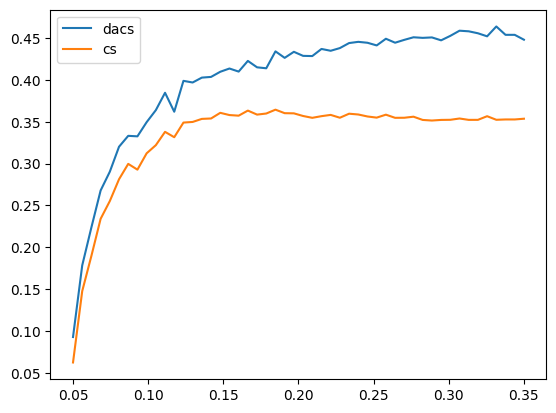

In [14]:
import matplotlib.pyplot as plt

plt.plot(np.linspace(0.05, 0.35, 50), setting1_diversities, label='dacs')
plt.plot(np.linspace(0.05, 0.35, 50), setting1_vanilla_diversities, label='cs')
plt.legend()
plt.show()

In [15]:
diversities = []
methodR = []
alphasR= []
serr = []


for ind in range(len(setting1_diversities)):
    diversities.append(setting1_diversities[ind])
    methodR.append("DACS")
    alphasR.append(np.linspace(0.05, 0.35, 50)[ind])
    serr.append(setting1_serr_diversities[ind])

    diversities.append(setting1_vanilla_diversities[ind])
    methodR.append("CS")
    alphasR.append(np.linspace(0.05, 0.35, 50)[ind])
    serr.append(setting1_serr_vanilla_diversities[ind])

tradeoff_df = pd.DataFrame({
    'diversity': diversities,
    'alpha': alphasR,
    'serr': serr,
    'method': methodR,
})

tradeoff_df.to_csv('./csvs_to_plot/tradeoff_results.csv')